In [2]:
import tarfile
import urllib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [3]:
ar5_df = pd.read_csv("apache.csv")
ar5_df['isDefective']=ar5_df['isDefective'].map({True:0,False:1})
print(ar5_df.info())
X = ar5_df.iloc[:,0:27]
#print(X)
True_val=ar5_df.iloc[:,27]
print(True_val)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     194 non-null    int64  
 1   AvgCyclomatic          194 non-null    int64  
 2   AvgCyclomaticModified  194 non-null    int64  
 3   AvgCyclomaticStrict    194 non-null    int64  
 4   AvgEssential           194 non-null    int64  
 5   AvgLine                194 non-null    int64  
 6   AvgLineBlank           194 non-null    int64  
 7   AvgLineCode            194 non-null    int64  
 8   AvgLineComment         194 non-null    int64  
 9   CountLine              194 non-null    int64  
 10  CountLineBlank         194 non-null    int64  
 11  CountLineCode          194 non-null    int64  
 12  CountLineCodeDecl      194 non-null    int64  
 13  CountLineCodeExe       194 non-null    int64  
 14  CountLineComment       194 non-null    int64  
 15  CountS

In [4]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(True_val)
true_labels[:56]

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [5]:
label_encoder.classes_

array([0, 1], dtype=int64)

In [6]:
n_clusters = len(label_encoder.classes_)

In [7]:
preprocessor = Pipeline(
        [
            ("scaler", MinMaxScaler()),
            ("pca", PCA(n_components=2, random_state=42)),
        ]
    )

In [8]:
clusterer = Pipeline(
       [
           (
               "kmeans",
               KMeans(
                   n_clusters=n_clusters,
                   init="k-means++",
                   n_init=50,
                   max_iter=500,
                   random_state=42,
               ),
           ),
       ]
    )

In [9]:
pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("clusterer", clusterer)
        ]
    )

In [10]:
pipe.fit(X)

Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('scaler',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1))),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
                                      n_components=2, random_state=42,
                                      svd_solver='auto', tol=0.0,
                                      whiten=False))],
                          verbose=False)),
                ('clusterer',
                 Pipeline(memory=None,
                          steps=[('kmeans',
                                  KMeans(algorithm='auto', copy_x=True,
                                         init='k-means++', max_iter=500,
                                         n_clusters=2, n_init=50, n_jobs=None,
                                         precomp

In [11]:
preprocessed_data = pipe["preprocessor"].transform(X)

predicted_labels = pipe["clusterer"]["kmeans"].labels_
print(silhouette_score(preprocessed_data, predicted_labels))
print(predicted_labels-true_labels)

0.5952145244341085
[ 0  0  0  0  0  0  0  0  0  0  1  1  0  1  0  0  1  0  1  0  0  0  1  0
  0  0  0  1  1  1  1  0  1  0 -1  0  1  0  0  1  1  1  0  0  1  0  1  0
  0  0  1  0  1  1  1  1  1  1  0  1  0  0  1  0  1  0  0  1  0  1  1  1
  1  0  0  1  0  0  0  1  1  1 -1 -1  0  0  0  0  0  0  1  0  1  0  0  1
  1  1  0  1  1  0  1  0  0  0  1  0  1  0  0  0  0  0  0 -1  0  0  0 -1
  0  0  1  1  1  0  0  0  0  0  0  0  1 -1  0  0  1  1  1  1  0  1  0  0
  1  1  1  0  1  0  0  0 -1  1  1  1  0  0  1  0  0  0  1  0  0  0  0  0
  0  0  1  0  0  0  0  0  0  1  0  1  1  0  0  0  0  1  0  0  1  1  0  0
  0  0]


In [12]:
adjusted_rand_score(true_labels, predicted_labels)

0.035435037639691115

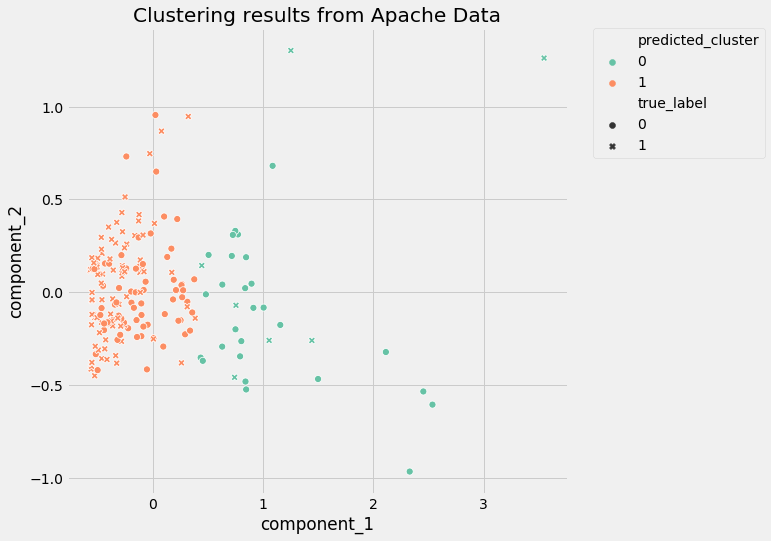

In [13]:
pcadf = pd.DataFrame(
        pipe["preprocessor"].transform(X),
        columns=["component_1", "component_2"],
    )
 
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

scat.set_title(
    "Clustering results from Apache Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [14]:
#print(true_labels)
original_clean=0
original_buggy=0
j=0
while j < len(true_labels):
    #print(true_labels[:j])
    if true_labels[j].size > 0:
        if true_labels[j]==1:
            original_buggy+=1
    j+=1
original_clean = len(true_labels) - original_buggy
print('original_clean ', original_clean)
print('original_buggy ', original_buggy)

original_clean  98
original_buggy  96


In [15]:
#print(predicted_labels)
predicted_clean=0
predicted_buggy=0
j=0
while j < len(predicted_labels):
    #print(predicted_labels[:j])
    if predicted_labels[j].size > 0:
        if predicted_labels[j]==1:
            predicted_buggy+=1
    j+=1
predicted_clean = len(predicted_labels) - predicted_buggy
print('predicted_clean ', predicted_clean)
print('predicted_buggy ', predicted_buggy)

predicted_clean  34
predicted_buggy  160


In [16]:
result=predicted_labels-true_labels
print(predicted_labels)
print(true_labels)
print(len(result))
count=0
i=0
while i <len(result):
    #print(result[i])
    if result[i]==0:
        count+=1
    i+=1
print('Accuracy ',count/len(result))

i=0
count=0
while i <len(result):
    #print(result[i])
    if result[i]==-1:
        count+=1
    i+=1
print('FN ',count)  

i=0
count=0
while i <len(result):
    #print(result[i])
    if result[i]==1:
        count+=1
    i+=1
print('FP',count) 

i=0
count=0
while i <len(result):
    #print(result[i])
    if predicted_labels[i]==0 & true_labels[i]==0:
        count+=1
    i+=1
print('TP ',count) 
i=0
count=0
while i <len(result):
    #print(result[i])
    if predicted_labels[i]==1 & true_labels[i]==1:
        count+=1
    i+=1
print('TN ',count)  

[0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1]
[0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0
 1 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1
 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1 0 1 0 1 1
 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1
 0 1 1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1
 0 1 1 0 0 1 1 0 1]
194
Accuracy  0.5979381443298969
FN  7
FP 71
TP  34
TN  89
